# Separation of satellites via differential drag

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context

This file was adapted from the tudatpy example application _Perturbed Satellite Orbit_.
It simulates the orbits of two LEO satellites separating via differential drag. The two satellites are 3U cubesats
(5kg each), but one of them has 3x the drag surface area of the other, because of different attitudes.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

NAIF's `SPICE` kernels are also loaded here, so that the position of various bodies such as the Earth, the Sun, and the Moon, can be make known to `tudatpy`.

In [1]:
# Load standard modules
import numpy as np

from matplotlib import pyplot as plt
from scipy import interpolate

# Load tudatpy modules
from tudatpy import constants
from tudatpy import numerical_simulation
from tudatpy.astro import element_conversion
from tudatpy.interface import spice_interface
from tudatpy.numerical_simulation import environment_setup, propagation_setup, propagation
from tudatpy.astro.time_conversion import DateTime

# Load spice kernels
spice_interface.load_standard_kernels()

## Creation of the environment
This includes both the vehicles and the celestial bodies.

### Creation of celestial bodies

First, we create body settings for the following celestial bodies:

- Sun
- Earth
- Moon

and we create these bodies by relying on default settings. 

In [2]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Creation of vehicle settings

We create two identical vehicles, called asterix and obelix, we set the mass and the aerodynamic coefficient 
interface (one satellite has 3X the surface of the other satellite). The main vehicle properties are:

- mass: 5 kg
- drag surface: 0.03 and 0.01 $m^2$
- aerodynamic coefficient: 1.2

In [3]:
# Create vehicle objects.
bodies.create_empty_body("asterix")
bodies.create_empty_body("obelix")

# Set mass of satellites
bodies.get("asterix").mass = 5.0
bodies.get("obelix").mass = 5.0

# Create aerodynamic coefficient interface settings and add it to the first satellite
reference_area = 0.1 * 0.1
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0, 0]
)
environment_setup.add_aerodynamic_coefficient_interface(
    bodies, "asterix", aero_coefficient_settings)

# Create aerodynamic coefficient interface settings and add it to the second satellite (3x surface area)
reference_area = 3 * 0.1 * 0.1
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0, 0]
)
environment_setup.add_aerodynamic_coefficient_interface(
    bodies, "obelix", aero_coefficient_settings)

## Creation of propagation settings

### Creation of acceleration settings

We set the (identical) accelerations acting on the satellites.
The dynamical model includes the following accelerations:

- spherical harmonic gravity exerted by the Earth, up to degree 2 and order 0
- aerodynamic
- point mass gravity of the Sun and the Moon

In [4]:
# Define bodies that are propagated.
bodies_to_propagate = ["asterix", "obelix"]

# Define central bodies.
central_bodies = ["Earth", "Earth"]

# Define accelerations acting on both satellites
accelerations_settings = dict(
    Sun=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 0),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
)

# Create global accelerations settings dictionary
acceleration_settings = {"asterix": accelerations_settings,
                         "obelix": accelerations_settings}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Set initial state

The satellites start at the same location. They are placed in a Sun-synchronous orbit at an altitude of 500km.
The initial conditions are given in  Kepler elements and later on converted to Cartesian elements.

In [5]:
# Retrieve Earth's gravitational parameter
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
# Retrieve Earth's radius
earth_radius = bodies.get("Earth").shape_model.average_radius
# Convert keplerian to cartesian elements
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=earth_radius + 500.0E3,
    eccentricity=0.0,
    inclination=np.deg2rad(97.4),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87)
)
# Both satellites have the same initial state
initial_states = np.concatenate((initial_state, initial_state))

### Set dependent variables to save
These include (for both satellites):

- the keplerian states
- the norm of the aerodynamic drag

In [6]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state("asterix", "Earth"),
    propagation_setup.dependent_variable.keplerian_state("obelix", "Earth"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "asterix", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "obelix", "Earth"
    ),
]

### Define termination settings

The simulation terminates when one of the two occurs:

- simulation time reaches 60 days
- angular separation between two satellites reaches 20 degrees

To achieve the second condition, a separate class is needed (see `AngleSeparationTermination`).
This class computes the angular separation between the two satellites at each step of the propagation and stores it
for post-processing. In addition, the class method `terminate_propagation()` is passed to the `custom()`
function to create termination settings to check whether the maximum angular separation has been reached.

The angular separation $\theta$ is computed by the `compute_angular_separation()` method as follows:

$$
\theta = \arccos \left( \frac {\mathbf{r_1} \cdot \mathbf{r_2}} {|\mathbf{r_1}| \cdot |\mathbf{r_2}|} \right)
$$

where $\mathbf{r_1}$ and $\mathbf{r_2}$ are the position vectors of the first and second satellites respectively.

In [7]:
from tudatpy.numerical_simulation.environment import SystemOfBodies

class AngleSeparationTermination:

    # Constructor
    def __init__(self, bodies: SystemOfBodies, maximum_angular_separation: float):
        """
        Constructor.

        Parameters
        ----------
        bodies : SystemOfBodies
            SystemOfBodies object.
        maximum_angular_separation : float
            Maximum angular separation (in rad) allowed before the propagation is stopped.
        """
        # Store input arguments as class attribute
        self.bodies = bodies
        self.maximum_angular_separation = maximum_angular_separation
        # Create container to store separation angle
        # The first element is needed because at the first epoch the termination settings are not checked
        self.separation_angle_history = [0.0]
        # Create termination reason to understand if time or angular separation triggered the termination
        self.termination_reason = "Final epoch of the propagation was reached."

    def compute_angular_separation(self, state_1: np.ndarray, state_2: np.ndarray):
        """
        Computes the angular separation between two objects.
        TODO: add valid range

        Parameters
        ----------
        state_1 : numpy.ndarray
            Cartesian state of the first object.
        state_2 : numpy.ndarray
            Cartesian state of the second object.

        Returns
        -------
        float
            Angle between the two objects.
        """
        # Check input for state 1
        if state_1.shape != (6, ):
            err_msg = "Input must be a cartesian state vector of 6 components, but the one provided has shape " \
                      + str(state_1.shape)
            raise ValueError(err_msg)
        # Check input for state 2
        if state_2.shape != (6, ):
            err_msg = "Input must be a cartesian state vector of 6 components, but the one provided has shape " \
                      + str(state_2.shape)
            raise ValueError(err_msg)
        # Get scalar product of position vector
        scalar_product = np.dot(state_1[:3], state_2[:3])
        # Compute the cosine of the separation angle
        cos_theta = scalar_product / (np.linalg.norm(state_1[:3]) * np.linalg.norm(state_2[:3]))
        # Check the validity of cosine
        # TODO: check this
        if cos_theta < -1.0:
            cos_theta = -1.0
        elif cos_theta > 1.0:
            cos_theta = 1.0
        # Compute separation angle
        separation_angle = np.arccos(cos_theta)
        return separation_angle

    def terminate_propagation(self, time: float):
        """
        Checks whether the maximum angular separation has been reached.

        This function is usually supplied to propagation_setup.termination.custom, so the function signature cannot
        be changed. The function is called at each time step and retrieves dynamically the state vector.

        Parameters
        ----------
        time : float
            Current time of the propagation (unused).

        Returns
        -------
        bool
            Whether the maximum angular separation has been reached.
        """
        # Retrieve states of the two objects
        state_1 = self.bodies.get("asterix").state
        state_2 = self.bodies.get("obelix").state
        # Compute angular separation
        separation_angle = self.compute_angular_separation(state_1, state_2)
        # Store separation angle
        self.separation_angle_history.append(separation_angle)
        # Check if the current angular separation exceeds the threshold
        if separation_angle >= self.maximum_angular_separation:
            stop_propagation = True
            self.termination_reason = "Maximum angular separation reached."
        else:
            stop_propagation = False
        return stop_propagation

Now the termination settings can be created.

In [8]:
# Set simulation start and end epochs
simulation_start_epoch = DateTime(2000, 1, 1).epoch()
simulation_end_epoch   = simulation_start_epoch + constants.JULIAN_DAY * 60.0

# Create object to compute angular separation
maximum_angular_separation = np.deg2rad(20.0)
angular_separation = AngleSeparationTermination(bodies, maximum_angular_separation)

# Set termination settings
# Time termination
time_termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)
# Custom termination
angle_termination_condition = propagation_setup.propagator.custom_termination(angular_separation.terminate_propagation)
# Create hybrid termination settings
termination_list = [time_termination_condition, angle_termination_condition]
hybrid_termination = propagation_setup.propagator.hybrid_termination(termination_list, fulfill_single_condition=True)

We use a variable step size Runge-Kutta-Fehlberg 7(8) integrator with relative and absolute tolerances equal to
$10^{-10}$.

In [9]:
# Create numerical integrator settings
initial_step_size = 10.0
maximum_step_size = 100.0
minimum_step_size = 1.0
tolerance = 1.0E-10
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    initial_step_size,
    propagation_setup.integrator.CoefficientSets.rkf_78,
    minimum_step_size,
    maximum_step_size,
    tolerance,
    tolerance)

The translational propagation settings are created here.

In [10]:
# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_states,
    simulation_start_epoch,
    integrator_settings,
    hybrid_termination,
    output_variables=dependent_variables_to_save
)

## Execute simulation
With these commands, we execute the simulation and retrieve the output.

In [11]:
# Create simulation object and propagate dynamics.
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings)
states = dynamics_simulator.state_history
dependent_variables = dynamics_simulator.dependent_variable_history

# Check which termination setting triggered the termination of the propagation
print("Termination reason:" + angular_separation.termination_reason)

Termination reason:Maximum angular separation reached.


## Post processing

The output is processed to produce the following figures:

1. kepler elements
2. drag acceleration norm
3. semi-major axis, with linear regression to see the difference in decay of both satellites
4. angular separation between the satellites (this is not the difference in true anomaly, because we don't know
how much the orbital plane changes, therefore the angular separation is computed as the angle between the two position
vectors).

Since the output is very dense, we interpolate the dependent variables to plot a more sparse
output. We do that via the `return_sparse_output()` function below.

In [12]:
def return_sparse_output(time_history, variable_history, datapoints=200):
    """
    Interpolates a time series of values and returns a "less dense" time series.

    Parameters
    ----------
    time_history : numpy.ndarray
        Vector of epochs.
    variable_history : numpy.ndarray
        Vector of values.
    datapoints : int
        Size of the sparse output vectors.

    Returns
    -------
    tuple(numpy.ndarray, numpy.ndarray)
        Sparse output vectors (time and values).
    """
    # Interpolate to get less dense output
    interp_function = interpolate.interp1d(time_history, variable_history)
    # Create vector of days to evaluate function
    time_interp = np.linspace(time[0], time[-1], datapoints)
    # Evaluate time vector
    interpolated_values = [interp_function(epoch) for epoch in time_interp]
    return time_interp, interpolated_values

We retrieve the output and convert it to `numpy` arrays.

In [13]:
# Get time and transform it in days
time = list(dependent_variables.keys())
time_days = [t / 3600 / 24 for t in time]

# Get states and dependent variables
states_list = np.vstack(list(states.values()))
dependent_variable_list = np.vstack(list(dependent_variables.values()))

### Kepler elements

To plot the kepler elements, we loop over each element, extract the correct element, make the necessary unit
conversions, and interpolate to produce a sparse output. This is replicated for each of the two satellites.

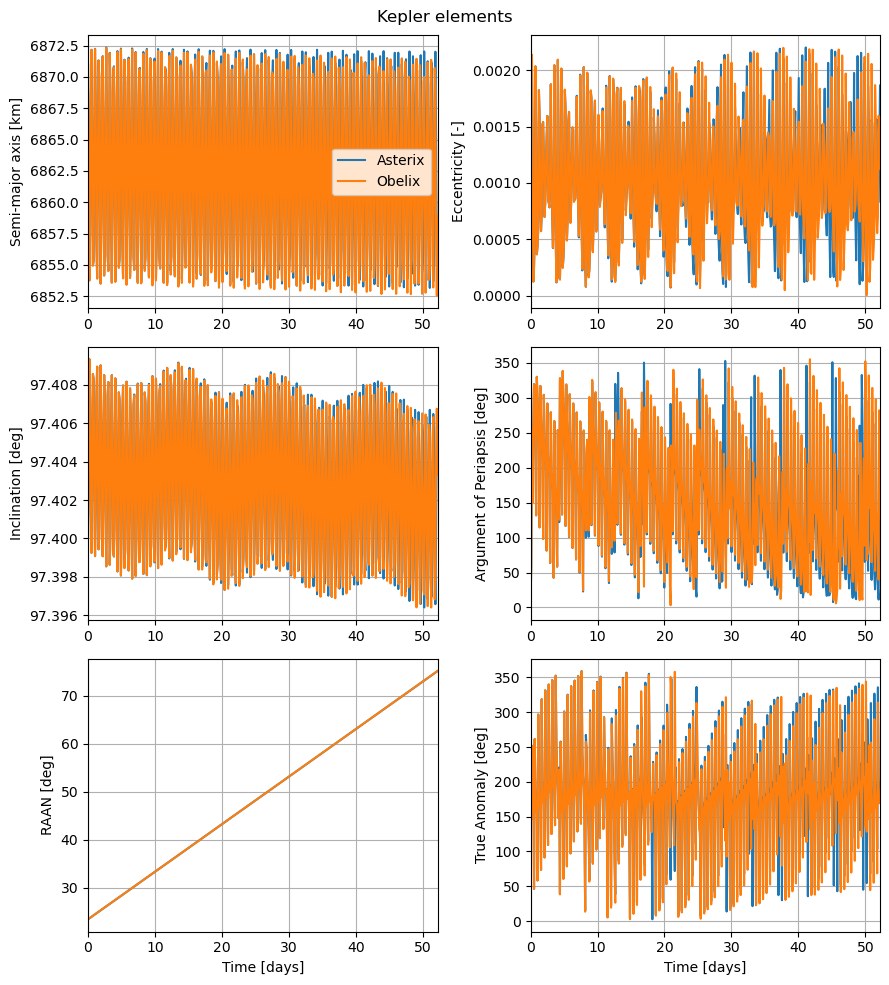

In [14]:
# Plot Kepler elements as a function of time
kepler_elements = dependent_variable_list[:, :12]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 10))
fig.suptitle('Kepler elements')

# Loop over Kepler elements in the following order
y_labels = ['Semi-major axis [km]',
            'Eccentricity [-]',
            'Inclination [deg]',
            'Argument of Periapsis [deg]',
            'RAAN [deg]',
            'True Anomaly [deg]']
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for element_number in range(6):
    # Retrieve element list for both satellites
    element_list_1 = kepler_elements[:, element_number]
    element_list_2 = kepler_elements[:, element_number + 6]
    # Convert semi-major axis to kilometers
    if element_number == 0:
        element_list_1 = [element / 1000 for element in element_list_1]
        element_list_2 = [element / 1000 for element in element_list_2]
        # Store semi-major axis for later
        sma_1 = element_list_1
        sma_2 = element_list_2
    # Convert radians to degrees
    elif element_number >= 2:
        element_list_1 = [np.rad2deg(element) for element in element_list_1]
        element_list_2 = [np.rad2deg(element) for element in element_list_2]
    # Interpolate to get less dense output
    time_interp_1, values_interp_1 = return_sparse_output(time, element_list_1, 500)
    time_interp_2, values_interp_2 = return_sparse_output(time, element_list_2, 500)
    # Convert time to days
    time_interp_days = [epoch / 24 / 3600.0 for epoch in time_interp_1]
    # Get current axis
    current_ax = axes[element_number]
    # Plot
    current_ax.plot(time_interp_days, values_interp_1, label="Asterix")
    current_ax.plot(time_interp_days, values_interp_2, label="Obelix")
    # Plot settings
    if element_number >= 4:
        current_ax.set_xlabel('Time [days]')
    current_ax.set_xlim([min(time_days), max(time_days)])
    current_ax.set_ylabel(y_labels[element_number])
    current_ax.grid()
    if element_number == 0:
        current_ax.legend()
        
plt.tight_layout()        

### Drag acceleration norm

We do something similar for the norm of the drag acceleration. The dependent variable saved is _already_ the norm, so
 we don't need to compute it ourselves.

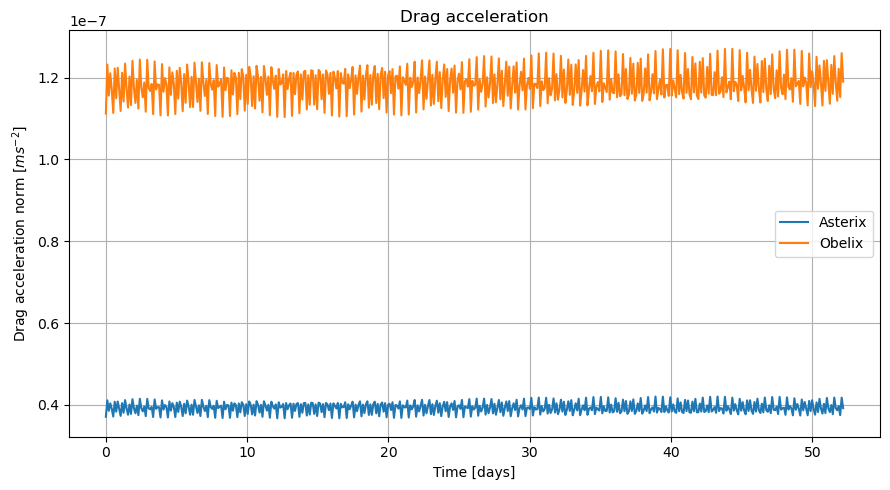

In [15]:
# Plot drag acceleration as a function of time
fig, ax = plt.subplots(figsize=(9, 5))
# Retrieve drag acceleration
drag_acceleration_norm_1 = dependent_variable_list[:, -2]
drag_acceleration_norm_2 = dependent_variable_list[:, -1]
# Interpolate to get less dense values
time_interp_1, drag_interp_1 = return_sparse_output(time, drag_acceleration_norm_1, 500)
time_interp_2, drag_interp_2 = return_sparse_output(time, drag_acceleration_norm_2, 500)
# Convert time to days
time_interp_days = [epoch / 24 / 3600.0 for epoch in time_interp_1]
# Plot values
ax.plot(time_interp_days, drag_interp_1, label="Asterix")
ax.plot(time_interp_days, drag_interp_2, label="Obelix")
# Plot settings
ax.set_xlabel('Time [days]')
ax.set_ylabel(r"Drag acceleration norm [$m s^{-2}$]")
ax.grid()
ax.set_title("Drag acceleration")
ax.legend()
plt.tight_layout()

As expected, the drag acceleration experienced by the satellite orbiting at a higher altitude (Asterix) is lower than
 the other satellite's drag acceleration. This happens because Obelix has 3 times the drag surface area of Asterix.

### Decay (semi-major axis trend)

Now we want to visualize the decay of the two satellites by plotting the trend of the semi-major axis. This allows to
 remove the periodic variations due to the higher-order spherical harmonic gravity. To do that, we use the
 `numpy.polyfit()` function.

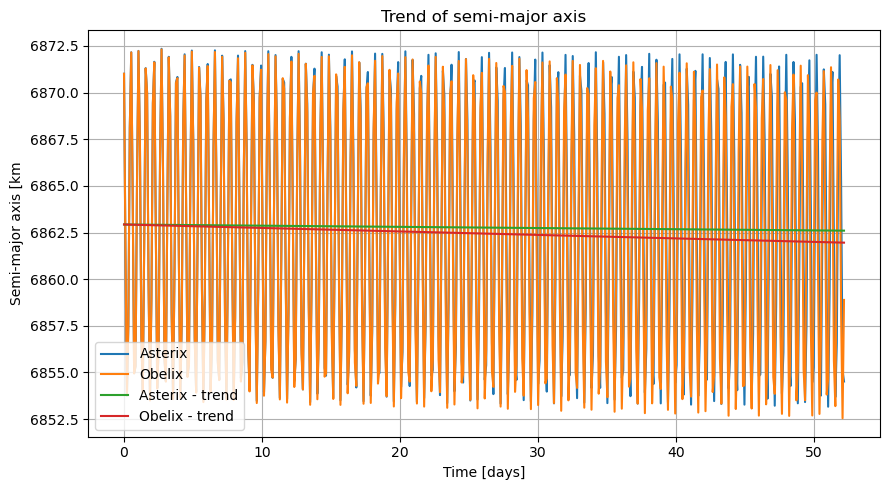

In [16]:
# Compute offset and trend of semi-major axis
# First satellite
ls = np.polyfit(list(time), sma_1, 1)
offset = ls[1]
slope = ls[0]
# Second satellite
ls_2 = np.polyfit(list(time), sma_2, 1)
offset_2 = ls_2[1]
slope_2 = ls_2[0]
# Create time vector to evaluate values and convert it to days
time_plot = np.linspace(time[0], time[-1], 2)
time_plot_days = [sec / 3600 / 24 for sec in time_plot]
# Create array of values
trend_1 = [offset + slope * el for el in list(time_plot)]
trend_2 = [offset_2 + slope_2 * el for el in list(time_plot)]
# Plot
fig, ax = plt.subplots(figsize=(9, 5))
# Interpolate values for semi-major axis
time_interp_1, sma_interp_1 = return_sparse_output(time, sma_1, 500)
time_interp_2, sma_interp_2 = return_sparse_output(time, sma_2, 500)
# Convert time to days
time_interp_days = [epoch / 24 / 3600.0 for epoch in time_interp_1]
# Plot values
ax.plot(time_interp_days, sma_interp_1, label="Asterix")
ax.plot(time_interp_days, sma_interp_2, label="Obelix")
# Plot trend
ax.plot(time_plot_days, trend_1, label="Asterix - trend")
ax.plot(time_plot_days, trend_2, label="Obelix - trend")
# Plot settings
ax.set_title("Trend of semi-major axis")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Semi-major axis [km")
ax.grid()
ax.legend(loc='lower left')
plt.tight_layout()

Due to the larger drag acceleration experienced by Obelix, the satellites decays at a faster rate.

### Angular separation

Finally, we plot the angular separation stored by the `AngleSeparationTermination` class.
This does not need any interpolation. As expected, the behavior is similar to a 2nd-degree polynomial, because the
difference in drag acceleration is almost constant (except for periodic oscillations in drag values). If we were to
extend the simulation time, the difference in drag acceleration would grow over time (and not be constant) because of
 larger density values at lower altitudes.

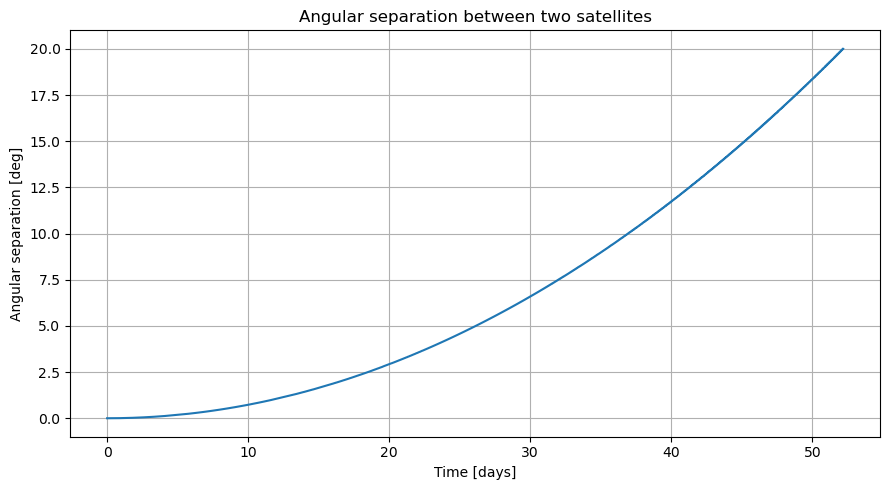

In [17]:
# Plot angular separation
angular_separation_list = np.rad2deg(angular_separation.separation_angle_history)
# Plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(time_days, angular_separation_list)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Angular separation [deg]")
ax.set_title("Angular separation between two satellites")
ax.grid()
plt.tight_layout()